In [2]:
import pandas as pd
import gurobipy as gb
from gurobipy import GRB
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Read data
data = pd.read_csv('bixi_plateau.csv', index_col=0)
data.head()

,STATIONNAME,ARRONDISSEMENT,LATITUDE,LONGITUDE,TIME,DAYOFWEEK,HOUR,DATE,DIRECTION,STATION_ID,CAPACITY
RIDEID,,,,,,,,,,,
9777838,Milton / Durocher,Le Plateau-Mont-Royal,45.508141,-73.574930,00:00:06.854000,Wednesday,0,2023-11-01,Departure,46,27.0
7630479,Bernard / Jeanne-Mance,Le Plateau-Mont-Royal,45.524287,-73.604973,00:00:20.846000,Wednesday,0,2023-11-01,Departure,286,23.0
9777660,Bernard / Jeanne-Mance,Le Plateau-Mont-Royal,45.524287,-73.604973,00:00:21.131000,Wednesday,0,2023-11-01,Departure,286,23.0
6234898,St-Hubert / Laurier,Le Plateau-Mont-Royal,45.529310,-73.588657,00:00:22.999000,Wednesday,0,2023-11-01,Departure,186,19.0
9669348,Calixa-Lavallée / Sherbrooke,Le Plateau-Mont-Royal,45.524790,-73.565450,00:00:57.435000,Wednesday,0,2023-11-01,Departure,147,19.0


In [4]:
data["DATE"] = pd.to_datetime(data["DATE"])
# Change the format so that date only shows the day and month
data["DATE"] = data["DATE"].dt.strftime('%m-%d')
data.head()

,STATIONNAME,ARRONDISSEMENT,LATITUDE,LONGITUDE,TIME,DAYOFWEEK,HOUR,DATE,DIRECTION,STATION_ID,CAPACITY
RIDEID,,,,,,,,,,,
9777838,Milton / Durocher,Le Plateau-Mont-Royal,45.508141,-73.574930,00:00:06.854000,Wednesday,0,11-01,Departure,46,27.0
7630479,Bernard / Jeanne-Mance,Le Plateau-Mont-Royal,45.524287,-73.604973,00:00:20.846000,Wednesday,0,11-01,Departure,286,23.0
9777660,Bernard / Jeanne-Mance,Le Plateau-Mont-Royal,45.524287,-73.604973,00:00:21.131000,Wednesday,0,11-01,Departure,286,23.0
6234898,St-Hubert / Laurier,Le Plateau-Mont-Royal,45.529310,-73.588657,00:00:22.999000,Wednesday,0,11-01,Departure,186,19.0
9669348,Calixa-Lavallée / Sherbrooke,Le Plateau-Mont-Royal,45.524790,-73.565450,00:00:57.435000,Wednesday,0,11-01,Departure,147,19.0


In [5]:
len(data["STATION_ID"].value_counts())

104

In [6]:
# Encode Arrival as 1 and Departure as -1
data['DIRECTION'] = data['DIRECTION'].apply(lambda x: 1 if x == 'Arrival' else -1)

In [7]:
# Create a lists of station names and capacities
stations = data['STATIONNAME'].unique()

print(stations)
print(len(stations))

capacities = [int(data[data['STATIONNAME'] == s]['CAPACITY'].values[0]) for s in stations]

print(capacities)
print(len(capacities))


['Milton / Durocher' 'Bernard / Jeanne-Mance' 'St-Hubert / Laurier'
 'Calixa-Lavallée / Sherbrooke' 'Fullum / Terrasse Mercure'
 'Émile-Duployé / Sherbrooke' 'Durocher / Sherbrooke'
 'Métro Sherbrooke (de Rigaud / Berri)' 'Prince-Arthur / du Parc'
 'Cartier / St-Joseph' 'St-Dominique / Laurier' 'Gilford / des Érables'
 'Calixa-Lavallée / Rachel' 'du Parc-Lafontaine / Rachel'
 'Laurier / St-Denis' 'Marie-Anne / Papineau' 'Milton / St-Laurent'
 'Milton / du Parc' 'Laurier / de Brébeuf' 'Rachel / de Brébeuf'
 'Henri-Julien / Laurier' 'de Bullion / St-Joseph' 'Aylmer / Sherbrooke'
 'Vallières / St-Laurent' 'Clark / Rachel' 'Coloniale / Duluth'
 'Jeanne-Mance / Laurier' 'Duluth  / St-Denis' 'Villeneuve / du Parc'
 'University / Prince-Arthur' 'Roy / St-André' 'Boyer / du Mont-Royal'
 'Berri / Rachel' 'de Lanaudière / du Mont-Royal' 'des Érables / Rachel'
 'Parthenais / du Mont-Royal' 'St-Grégoire / Christophe-Colomb'
 'Marquette / du Mont-Royal' 'St-Dominique / Napoléon'
 'St-Dominique / du

In [8]:
# Create a function that will select the rows corresponding to the selected date 
def select_data(date, data):
    return data[data['DATE'] == date]

In [9]:
# Create a function that will create a list of dataframes, each corresponding to different dates of the same day of the week
def select_data_weekday(weekday, data):
    # select the rows corresponding to the selected weekday
    data_weekday = data[data['WEEKDAY'] == weekday]

    # create a list of dataframes, each corresponding to a different date
    dates = data_weekday['DATE'].unique()
    data_list = [select_data(date, data_weekday) for date in dates]

    return data_list

In [10]:
# Select data for the first of november
data_1101 = select_data('11-01', data)

# Make sure teh data is ordered from oldest to newest
data_1101 = data_1101.sort_values(by='TIME')

# Select the rows starting from 7:00
data_1101 = data_1101[data_1101['TIME'] >= '07:00']
data_1101.head()

,STATIONNAME,ARRONDISSEMENT,LATITUDE,LONGITUDE,TIME,DAYOFWEEK,HOUR,DATE,DIRECTION,STATION_ID,CAPACITY
RIDEID,,,,,,,,,,,
9363645,Casgrain / Maguire,Le Plateau-Mont-Royal,45.525933,-73.595253,07:00:00.637000,Wednesday,6,11-01,1,640,23.0
8591801,Durocher / Sherbrooke,Le Plateau-Mont-Royal,45.507076,-73.572285,07:00:43.567000,Wednesday,7,11-01,-1,255,23.0
7146361,Berri / Cherrier,Le Plateau-Mont-Royal,45.519088,-73.569509,07:01:22.210000,Wednesday,6,11-01,1,173,39.0
7146125,St-Dominique / Laurier,Le Plateau-Mont-Royal,45.523615,-73.592457,07:01:42.723000,Wednesday,7,11-01,-1,294,23.0
7146215,des Pins / Hutchison,Le Plateau-Mont-Royal,45.510928,-73.578158,07:01:46.508000,Wednesday,6,11-01,1,324,23.0


Now that we have the data for the time period we want to prepare for. Lets create a model to find what amount of bikes to have at each station.

In [11]:
# Create a lists of station names, capacities, and directions
stations = data_1101['STATIONNAME'].unique()
print(stations)
range_stations = range(len(stations))
print(len(stations))


['Casgrain / Maguire' 'Durocher / Sherbrooke' 'Berri / Cherrier'
 'St-Dominique / Laurier' 'des Pins / Hutchison'
 'St-Grégoire / Christophe-Colomb' 'Métro Laurier (Berri / St-Joseph)'
 'Marie-Anne / de la Roche' 'des Pins / St-Laurent' 'Laurier / de Brébeuf'
 'Jeanne-Mance / Laurier' 'Boyer / du Mont-Royal' 'Laurier / St-Denis'
 'Cartier / St-Joseph' 'de Gaspé / St-Viateur' 'Gilford / des Érables'
 "de l'Esplanade / du Mont-Royal" 'Hutchison / Prince-Arthur'
 'Parthenais / du Mont-Royal' 'Villeneuve / du Parc'
 'Clark / Prince-Arthur' 'Parc Jeanne-Mance (du Mont-Royal / du Parc)'
 'Berri / Rachel' 'Fullum / Gilford' 'Marquette / du Mont-Royal'
 'de Lanaudière / du Mont-Royal' 'Labadie / du Parc'
 'Marie-Anne / St-Hubert' 'Fullum / Terrasse Mercure' 'Coloniale / Duluth'
 'Aylmer / Sherbrooke' 'Calixa-Lavallée / Sherbrooke'
 'Métro Sherbrooke (de Rigaud / Berri)' 'Aylmer / Prince-Arthur'
 'des Érables / Rachel' 'Prince-Arthur / du Parc' 'du Mont-Royal / Clark'
 'St-Dominique / du Mont-R

Finding the optimal number of bikes for each of the stations indepenentrly from each other means that it can be solved faster if they are calculated independently

In [12]:
results_list = []  # Initialize a list to store results

for station in stations:
    # Select the rows corresponding to the station
    data_station = data_1101[data_1101['STATIONNAME'] == station].sort_values(by='TIME')

    # Get the station parameters
    capacity = int(data_station['CAPACITY'].values[0])
    demand_direction = data_station['DIRECTION'].values
    number_of_demands = len(demand_direction)

    # Initialize the model:
    model = gb.Model("Station Optimization")
    model.Params.LogToConsole = 0  # Suppress output details

    # Create the variables
    x = model.addVar(lb=0, ub=capacity, vtype=GRB.INTEGER, name="Initial Bikes")
    Y = model.addVars(range(len(demand_direction)), vtype=GRB.BINARY, name="Y")
    Z = model.addVars(range(len(demand_direction) + 1), vtype=GRB.INTEGER, name="Bikes")

    # Set the objective
    model.setObjective(gb.quicksum(Y[i] for i in range(len(demand_direction))) / len(demand_direction), GRB.MAXIMIZE)

    # Add the constraints
    model.addConstr(Z[0] == x, name="InitialAllocation")

    model.addConstrs((Y[i] <= Z[i] for i in range(len(demand_direction)) if demand_direction[i] == -1), name="OutgoingDemand")
    model.addConstrs((Y[i] <= capacity - Z[i] for i in range(len(demand_direction)) if demand_direction[i] == 1), name="IncomingDemand")
    model.addConstrs((Z[i+1] == Z[i] + demand_direction[i] * Y[i] for i in range(len(demand_direction))), name="BikeUpdate")

    # Optimize the model
    model.optimize()

    # Store the results
    if model.status == GRB.OPTIMAL:
        results_list.append({
            'STATIONNAME': station,
            'OPTIMAL_ALLOCATION': int(x.X),
            'SATISFIED_DEMAND': model.objVal,
            'CAPACITY': capacity,
            'NUMBER_OF_DEMANDS' : number_of_demands
        })

# Convert results list to a DataFrame
results = pd.DataFrame(results_list)

# Display the results
display(results)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-03


,STATIONNAME,OPTIMAL_ALLOCATION,SATISFIED_DEMAND,CAPACITY,NUMBER_OF_DEMANDS
0,Casgrain / Maguire,3,1.000000,23,134
1,Durocher / Sherbrooke,11,0.929245,23,212
2,Berri / Cherrier,38,0.919679,39,249
3,St-Dominique / Laurier,19,0.990783,23,217
4,des Pins / Hutchison,8,1.000000,23,260
...,...,...,...,...,...
98,St-Dominique / Bernard,4,0.987952,19,83
99,Milton / St-Laurent,7,1.000000,21,160
100,Waverly / Van Horne,13,1.000000,15,64
101,du Parc-La Fontaine / Roy,7,1.000000,19,83


In [13]:
results.describe()

,OPTIMAL_ALLOCATION,SATISFIED_DEMAND,CAPACITY,NUMBER_OF_DEMANDS
count,103.000000,103.000000,103.000000,103.000000
mean,16.126214,0.986685,24.145631,173.388350
std,8.054568,0.031018,6.587879,91.368596
min,0.000000,0.812500,15.000000,36.000000
25%,10.500000,0.990230,19.000000,107.500000
50%,16.000000,1.000000,23.000000,155.000000
75%,21.000000,1.000000,27.000000,210.500000
max,42.000000,1.000000,48.000000,467.000000


For the following problems we will take into consideration only the 10 most popular stations for computational reasons

In [14]:
# Get the 10 stations with the most demand
results = results.sort_values(by='NUMBER_OF_DEMANDS', ascending=False)
top_10 = results.head(10)
top_10

,STATIONNAME,OPTIMAL_ALLOCATION,SATISFIED_DEMAND,CAPACITY,NUMBER_OF_DEMANDS
8,des Pins / St-Laurent,22,0.972163,23,467
36,du Mont-Royal / Clark,30,1.000000,39,454
35,Prince-Arthur / du Parc,20,1.000000,35,430
24,Marquette / du Mont-Royal,16,1.000000,23,423
81,Métro Mont-Royal (Utilités publiques / Rivard),16,1.000000,23,420
20,Clark / Prince-Arthur,27,0.982507,31,343
12,Laurier / St-Denis,25,1.000000,37,337
97,University / Prince-Arthur,0,0.917431,47,327
33,Aylmer / Prince-Arthur,11,0.990769,31,325
11,Boyer / du Mont-Royal,22,0.983333,27,300


Get the optimal number of bikes for the 10 sleceted stations given a maximum number of total bikes across all stations:

In [15]:
# Get the data corresponding to the 10 stations
data_10 = data_1101[data_1101['STATIONNAME'].isin(top_10['STATIONNAME'])]

# Get the capacities of the 10 stations and the directions of the demands
stations = data_10['STATIONNAME'].unique()
print(stations)

capacities = [int(data_10[data_10['STATIONNAME'] == s]['CAPACITY'].values[0]) for s in top_10['STATIONNAME']]
print(capacities)

directions = pd.Series(data_10['DIRECTION'].values)
print(directions)

station_indices = [stations.tolist().index(s) for s in data_10['STATIONNAME']]
print(station_indices)

range_stations = range(len(stations))
range_demand = range(len(directions))

['des Pins / St-Laurent' 'Boyer / du Mont-Royal' 'Laurier / St-Denis'
 'Clark / Prince-Arthur' 'Marquette / du Mont-Royal'
 'Aylmer / Prince-Arthur' 'Prince-Arthur / du Parc'
 'du Mont-Royal / Clark' 'Métro Mont-Royal (Utilités publiques / Rivard)'
 'University / Prince-Arthur']
[23, 39, 35, 23, 23, 31, 37, 47, 31, 27]
0       1
1       1
2       1
3       1
4       1
       ..
3821    1
3822   -1
3823    1
3824   -1
3825    1
Length: 3826, dtype: int64
[0, 1, 2, 3, 4, 5, 2, 6, 7, 5, 0, 3, 5, 0, 4, 4, 2, 7, 2, 7, 6, 0, 1, 7, 8, 8, 2, 8, 0, 7, 7, 0, 7, 1, 2, 7, 6, 1, 0, 2, 3, 1, 7, 1, 8, 2, 1, 4, 4, 7, 5, 3, 7, 1, 2, 1, 6, 7, 3, 0, 6, 1, 0, 0, 2, 5, 2, 2, 3, 2, 8, 7, 5, 3, 9, 7, 1, 1, 5, 7, 2, 8, 0, 1, 5, 0, 5, 2, 7, 7, 4, 8, 5, 7, 1, 7, 4, 9, 8, 7, 9, 2, 2, 0, 6, 5, 5, 6, 9, 4, 8, 5, 5, 2, 1, 4, 0, 7, 2, 2, 5, 9, 6, 4, 1, 8, 2, 8, 6, 2, 4, 5, 3, 1, 7, 8, 5, 7, 0, 2, 6, 5, 0, 8, 8, 0, 5, 4, 9, 6, 7, 7, 9, 6, 2, 0, 4, 2, 4, 4, 6, 5, 9, 7, 9, 7, 0, 0, 7, 2, 6, 7, 9, 5, 5, 2, 2, 7, 1, 7, 5

Given that the optimal alocation for these stations without the max amount of bikes is above, the allocation should be the same if we have equal or more bikes available

In [18]:
# Get the total amount of bikes used in the optimal alocation of the top 10 stations
total_bikes = sum(top_10["OPTIMAL_ALLOCATION"])
print(total_bikes)

189


In [19]:
# Changing the total amount of bikes to
total_bikes = 250

total_bikes
# Initialize the model:
model = gb.Model("Station Optimization max bikes")
model.Params.LogToConsole = 0 # Asking Gurobi not to give us all the details!

# Create the decision variables:
x = model.addVars(range_stations, vtype=GRB.INTEGER, name=["Initial bikes at station " + s for s in stations])
y = model.addVars(range_demand, vtype=GRB.BINARY, name=["Demand met at time " + str(i) for i in range_demand])
z = model.addVars(range_stations, range(len(directions) + 1), vtype=GRB.INTEGER, name="BikesAfterTime")

# Objective function: Maximize average demand met
avg_met_demand = gb.quicksum(y[i] for i in range_demand) / len(range_demand)
model.setObjective(avg_met_demand, GRB.MAXIMIZE)

# Constraints
# Initial setup
model.addConstrs((z[s, 0] == x[s] for s in range_stations), name="InitialAllocation")

# Boundary constraints for x and z
model.addConstrs((x[s] >= 0 for s in range_stations), name="InitialLowerLimit")
model.addConstrs((x[s] <= capacities[s] for s in range_stations), name="InitialUpperLimit")
model.addConstrs((z[s, i] >= 0 for s in range_stations for i in range(len(directions) + 1)), name="NonNegativeInventory")
model.addConstrs((z[s, i] <= capacities[s] for s in range_stations for i in range(len(directions) + 1)), name="CapacityLimit")

# Demand satisfaction conditions
model.addConstrs((
    y[i] <= z[station_indices[i], i]
    for i in range_demand if directions[i] == -1
), name="OutgoingDemand")

model.addConstrs((
    y[i] <= capacities[station_indices[i]] - z[station_indices[i], i]
    for i in range_demand if directions[i] == 1
), name="IncomingDemand")

# Bike inventory dynamics (linking station-specific updates)
model.addConstrs((
    z[s, i+1] == z[s, i] + (y[i] if station_indices[i] == s else 0) * directions[i]
    for s in range_stations for i in range_demand
), name="UpdateBikes")

# Max amount of initial bikes
model.addConstr(gb.quicksum(x[i] for i in range_stations) <= total_bikes, name = "Maximum amount of initial bikes")

# Solve the model
model.optimize()

# Return results
if model.status == GRB.OPTIMAL:
    # Objective value
    obj_value = model.ObjVal
    print(f"Objective Function Value (Average Met Demand): {obj_value}")
    
    # Values of x with the station name
    x_values = {s: x[s].X for s in range_stations}
    print("Initial Allocation of Bikes at Each Station:")
    for s in range_stations:
        print(f"{stations[s]}: {x_values[s]}")

    # Total amount of bikes used
    total_bikes = sum(x_values.values())
    print(f"Total amount of bikes used: {total_bikes}")

    # Create variables to be reused for the TSP problem
    optimal_allocation = list(x_values.values())
    # save the bike allocation at the end of the day as a list
    eod_allocation = [z[s, (len(directions))].X for s in range_stations]
else:
    print("No optimal solution found.")

Objective Function Value (Average Met Demand): 0.9746471510716064
Initial Allocation of Bikes at Each Station:
des Pins / St-Laurent: 22.0
Boyer / du Mont-Royal: 27.0
Laurier / St-Denis: 25.0
Clark / Prince-Arthur: 19.0
Marquette / du Mont-Royal: 16.0
Aylmer / Prince-Arthur: 11.0
Prince-Arthur / du Parc: 20.0
du Mont-Royal / Clark: 30.0
Métro Mont-Royal (Utilités publiques / Rivard): 16.0
University / Prince-Arthur: -0.0
Total amount of bikes used: 186.0


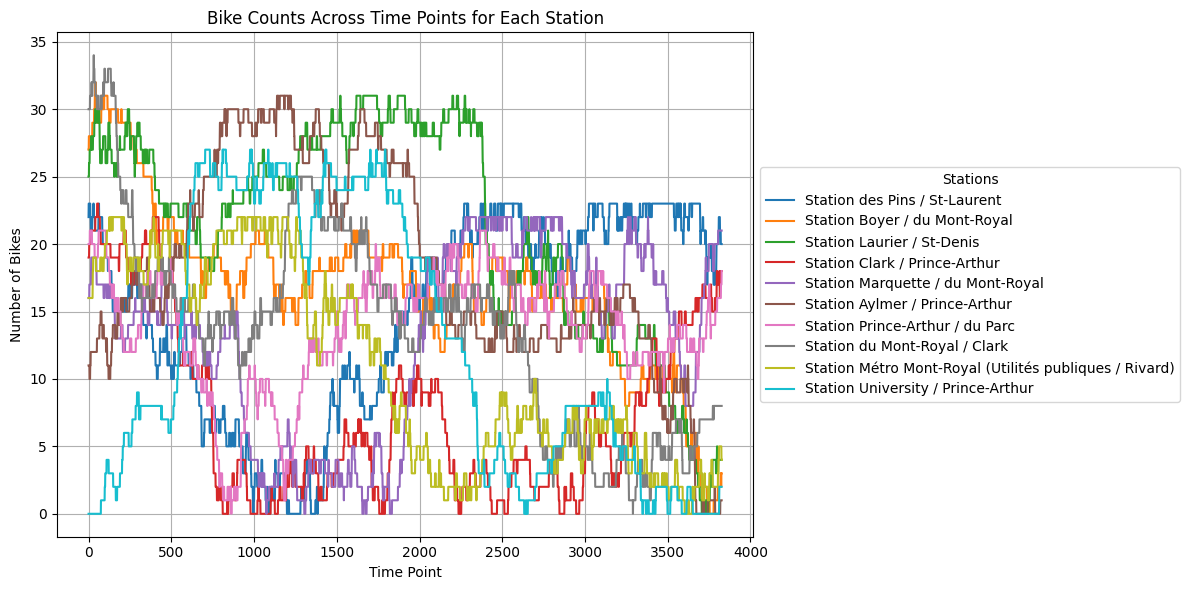

In [20]:
# Extract the bike counts at each time point for each station
if model.status == GRB.OPTIMAL:
    time_points = range(len(directions) + 1)
    bike_counts = {s: [z[s, i].X for i in time_points] for s in range_stations}
    
    # Plot the results
    plt.figure(figsize=(12, 6))  # Adjust width for space for side legend
    
    for s in range_stations:
        plt.plot(time_points, bike_counts[s], label=f"Station {stations[s]}")
    
    plt.title("Bike Counts Across Time Points for Each Station")
    plt.xlabel("Time Point")
    plt.ylabel("Number of Bikes")
    plt.grid(True)
    
    # Place the legend on the side
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Stations")
    
    plt.tight_layout()
    plt.show()
else:
    print("No optimal solution found. Unable to plot bike counts.")

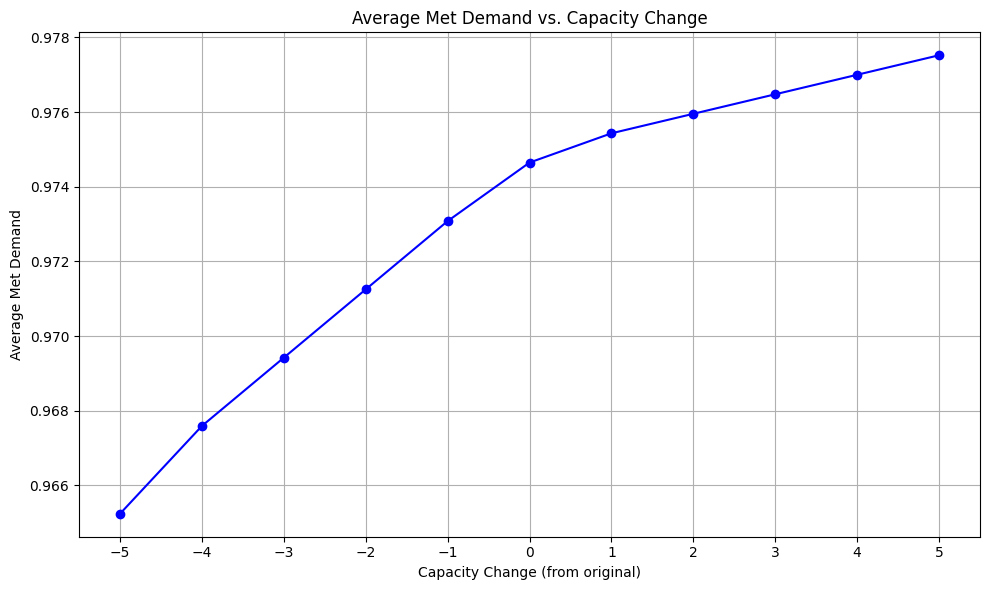

In [21]:
# Initialize results storage
average_met_demand_results = []

# Define the range of capacity changes (-5 to 5)
capacity_changes = range(-5, 6)

# Loop through each capacity change
for change in capacity_changes:
    # Adjust capacities for the current iteration
    adjusted_capacities = [max(0, cap + change) for cap in capacities]  # Ensure capacities are non-negative
    
    # Create the model
    model = gb.Model("Station Optimization with Varying Capacities")
    model.Params.LogToConsole = 0  # Suppress output
    
    # Decision variables
    x = model.addVars(range_stations, vtype=gb.GRB.INTEGER, name=["Initial bikes at station " + s for s in stations])
    y = model.addVars(range_demand, vtype=gb.GRB.BINARY, name=["Demand met at time " + str(i) for i in range_demand])
    z = model.addVars(range_stations, range(len(directions) + 1), vtype=gb.GRB.INTEGER, name="BikesAfterTime")
    
    # Objective function
    avg_met_demand = gb.quicksum(y[i] for i in range_demand) / len(range_demand)
    model.setObjective(avg_met_demand, gb.GRB.MAXIMIZE)
    
    # Constraints
    model.addConstrs((z[s, 0] == x[s] for s in range_stations), name="InitialAllocation")
    model.addConstrs((x[s] >= 0 for s in range_stations), name="InitialLowerLimit")
    model.addConstrs((x[s] <= adjusted_capacities[s] for s in range_stations), name="InitialUpperLimit")
    model.addConstrs((z[s, i] >= 0 for s in range_stations for i in range(len(directions) + 1)), name="NonNegativeInventory")
    model.addConstrs((z[s, i] <= adjusted_capacities[s] for s in range_stations for i in range(len(directions) + 1)), name="CapacityLimit")
    model.addConstrs((
        y[i] <= z[station_indices[i], i]
        for i in range_demand if directions[i] == -1
    ), name="OutgoingDemand")
    model.addConstrs((
        y[i] <= adjusted_capacities[station_indices[i]] - z[station_indices[i], i]
        for i in range_demand if directions[i] == 1
    ), name="IncomingDemand")
    model.addConstrs((
        z[s, i+1] == z[s, i] + (y[i] if station_indices[i] == s else 0) * directions[i]
        for s in range_stations for i in range_demand
    ), name="UpdateBikes")
    model.addConstr(gb.quicksum(x[i] for i in range_stations) <= total_bikes, name="Maximum amount of initial bikes")
    
    # Solve the model
    model.optimize()
    
    # Store the average met demand if the model solves optimally
    if model.status == gb.GRB.OPTIMAL:
        average_met_demand_results.append(model.ObjVal)
    else:
        average_met_demand_results.append(None)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(capacity_changes, average_met_demand_results, marker='o', linestyle='-', color='b')
plt.title("Average Met Demand vs. Capacity Change")
plt.xlabel("Capacity Change (from original)")
plt.ylabel("Average Met Demand")
plt.grid(True)
plt.xticks(capacity_changes)  # Ensure x-axis ticks align with capacity changes
plt.tight_layout()
plt.show()


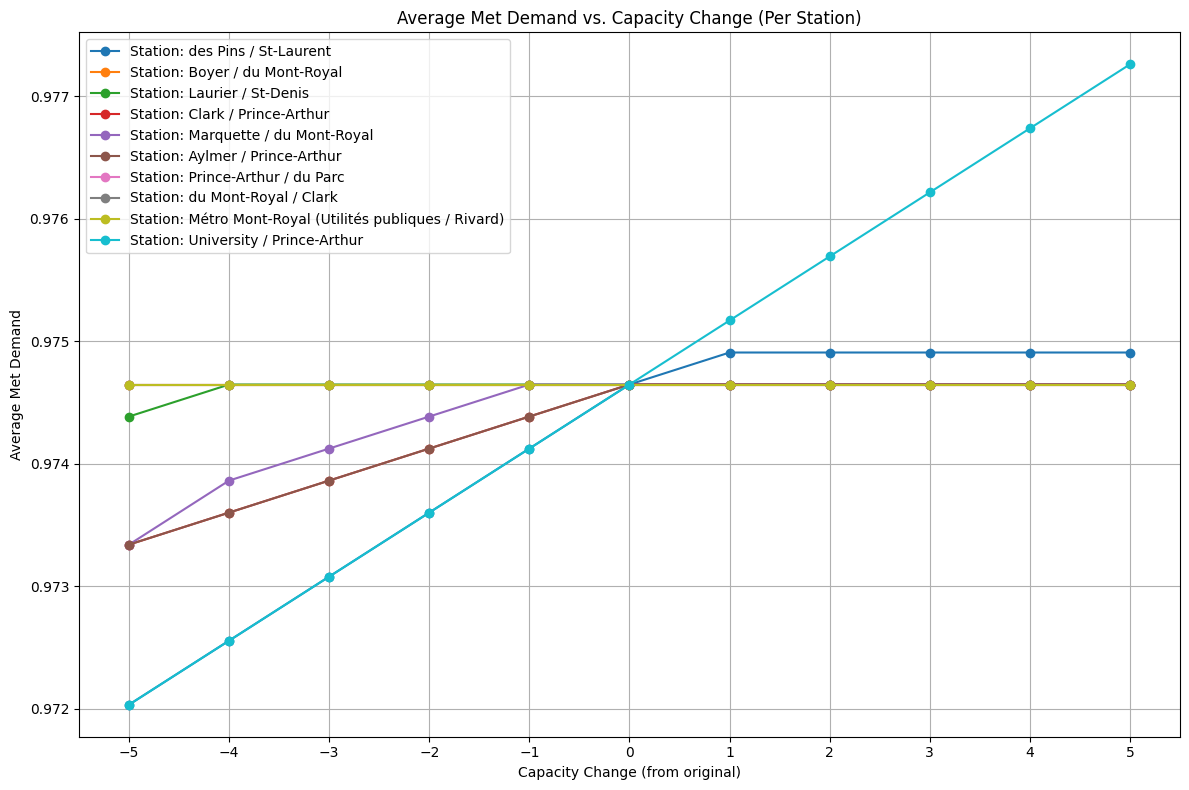

In [22]:
import gurobipy as gb
import matplotlib.pyplot as plt

# Initialize storage for results
results_by_station = {}

# Loop through each station
for s in range_stations:
    # Store the results for the current station
    station_results = []
    
    # Loop through capacity changes for the current station
    for change in range(-5, 6):
        # Adjust capacities: Only the current station's capacity is modified
        adjusted_capacities = capacities.copy()
        adjusted_capacities[s] = max(0, capacities[s] + change)  # Ensure non-negative capacity
        
        # Create the model
        model = gb.Model("Station Optimization with Single-Station Capacity Adjustment")
        model.Params.LogToConsole = 0  # Suppress output
        
        # Decision variables
        x = model.addVars(range_stations, vtype=gb.GRB.INTEGER, name=["Initial bikes at station " + s for s in stations])
        y = model.addVars(range_demand, vtype=gb.GRB.BINARY, name=["Demand met at time " + str(i) for i in range_demand])
        z = model.addVars(range_stations, range(len(directions) + 1), vtype=gb.GRB.INTEGER, name="BikesAfterTime")
        
        # Objective function
        avg_met_demand = gb.quicksum(y[i] for i in range_demand) / len(range_demand)
        model.setObjective(avg_met_demand, gb.GRB.MAXIMIZE)
        
        # Constraints
        model.addConstrs((z[s, 0] == x[s] for s in range_stations), name="InitialAllocation")
        model.addConstrs((x[s] >= 0 for s in range_stations), name="InitialLowerLimit")
        model.addConstrs((x[s] <= adjusted_capacities[s] for s in range_stations), name="InitialUpperLimit")
        model.addConstrs((z[s, i] >= 0 for s in range_stations for i in range(len(directions) + 1)), name="NonNegativeInventory")
        model.addConstrs((z[s, i] <= adjusted_capacities[s] for s in range_stations for i in range(len(directions) + 1)), name="CapacityLimit")
        model.addConstrs((
            y[i] <= z[station_indices[i], i]
            for i in range_demand if directions[i] == -1
        ), name="OutgoingDemand")
        model.addConstrs((
            y[i] <= adjusted_capacities[station_indices[i]] - z[station_indices[i], i]
            for i in range_demand if directions[i] == 1
        ), name="IncomingDemand")
        model.addConstrs((
            z[s, i+1] == z[s, i] + (y[i] if station_indices[i] == s else 0) * directions[i]
            for s in range_stations for i in range_demand
        ), name="UpdateBikes")
        model.addConstr(gb.quicksum(x[i] for i in range_stations) <= total_bikes, name="Maximum amount of initial bikes")
        
        # Solve the model
        model.optimize()
        
        # Store the average met demand if the model solves optimally
        if model.status == gb.GRB.OPTIMAL:
            station_results.append(model.ObjVal)
        else:
            station_results.append(None)
    
    # Store results for this station
    results_by_station[stations[s]] = station_results

# Plot the results
plt.figure(figsize=(12, 8))
for station, results in results_by_station.items():
    plt.plot(range(-5, 6), results, marker='o', linestyle='-', label=f"Station: {station}")

plt.title("Average Met Demand vs. Capacity Change (Per Station)")
plt.xlabel("Capacity Change (from original)")
plt.ylabel("Average Met Demand")
plt.grid(True)
plt.legend(loc="best")
plt.xticks(range(-5, 6))  # Ensure x-axis ticks align with capacity changes
plt.tight_layout()
plt.show()


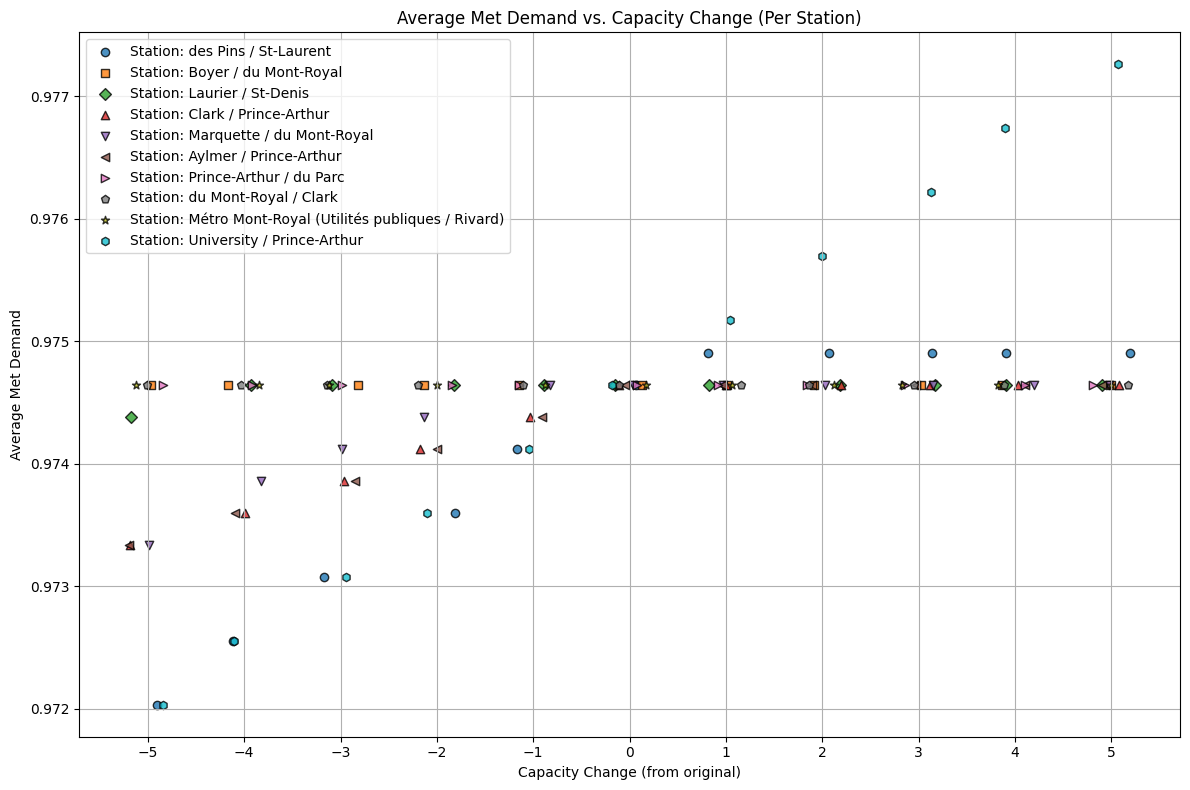

In [27]:
import numpy as np
# Jitter function
def add_jitter(values, scale=0.1):
    return values + np.random.uniform(-scale, scale, size=len(values))

# Plot the results with jitter and different markers
plt.figure(figsize=(12, 8))
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H']  # Unique markers for each station
colors = plt.cm.tab10.colors  # Cycle through a color map

for idx, (station, results) in enumerate(results_by_station.items()):
    jittered_x = add_jitter(np.array(range(-5, 6)), scale=0.2)  # Add jitter to x-values
    plt.scatter(jittered_x, results, label=f"Station: {station}", marker=markers[idx % len(markers)], color=colors[idx % len(colors)], alpha=0.8, edgecolor='k')

plt.title("Average Met Demand vs. Capacity Change (Per Station)")
plt.xlabel("Capacity Change (from original)")
plt.ylabel("Average Met Demand")
plt.grid(True)
plt.legend(loc="best")
plt.xticks(range(-5, 6))  # Ensure x-axis ticks align with capacity changes
plt.tight_layout()
plt.show()


Comparison with the  results from the independent models: 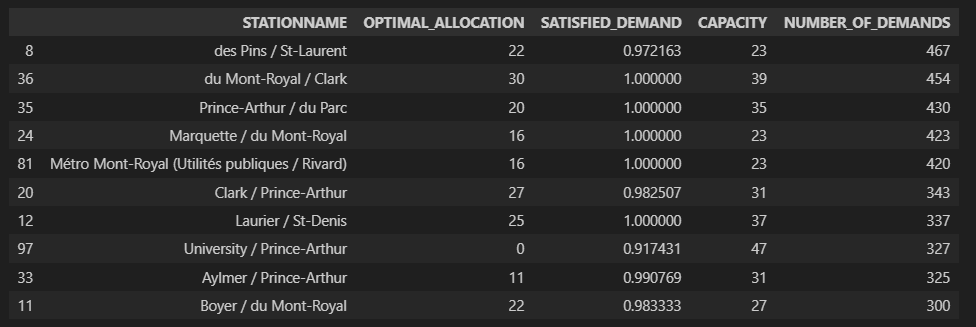

In [20]:
# get the total capacity of the stations
total_capacity = sum(capacities)
print(total_capacity)

316


In [21]:
print(optimal_allocation)
print(sum(optimal_allocation))
print(eod_allocation)
print(sum(eod_allocation))


[22.0, 27.0, 25.0, 19.0, 16.0, 11.0, 20.0, 30.0, 16.0, -0.0]
186.0
[20.0, 3.0, 4.0, 18.0, 21.0, 1.0, 18.0, 8.0, 4.0, 2.0]
99.0


Now lets have a a limit to the total number of initial bikes and itterate from 0 to the max number and force the number to be equal to the total amount of bikes. Watch out takes a lot of time for this range probably ~20min

In [165]:
# Changing the total amount of bikes to
bikes = range(0, 316)
results_list = []  # Initialize a list to store results

for total_bikes in bikes:
    # Initialize the model:
    model = gb.Model("Station Optimization max bikes")
    model.Params.LogToConsole = 0 # Asking Gurobi not to give us all the details!

    # Create the decision variables:
    x = model.addVars(range_stations, vtype=GRB.INTEGER, name=["Initial bikes at station " + s for s in stations])
    y = model.addVars(range_demand, vtype=GRB.BINARY, name=["Demand met at time " + str(i) for i in range_demand])
    z = model.addVars(range_stations, range(len(directions) + 1), vtype=GRB.INTEGER, name="BikesAfterTime")

    # Objective function: Maximize average demand met
    avg_met_demand = gb.quicksum(y[i] for i in range_demand) / len(range_demand)
    model.setObjective(avg_met_demand, GRB.MAXIMIZE)

    # Constraints
    # Initial setup
    model.addConstrs((z[s, 0] == x[s] for s in range_stations), name="InitialAllocation")

    # Boundary constraints for x and z
    model.addConstrs((x[s] >= 0 for s in range_stations), name="InitialLowerLimit")
    model.addConstrs((x[s] <= capacities[s] for s in range_stations), name="InitialUpperLimit")
    model.addConstrs((z[s, i] >= 0 for s in range_stations for i in range(len(directions) + 1)), name="NonNegativeInventory")
    model.addConstrs((z[s, i] <= capacities[s] for s in range_stations for i in range(len(directions) + 1)), name="CapacityLimit")

    # Demand satisfaction conditions
    model.addConstrs((
        y[i] <= z[station_indices[i], i]
        for i in range_demand if directions[i] == -1
    ), name="OutgoingDemand")

    model.addConstrs((
        y[i] <= capacities[station_indices[i]] - z[station_indices[i], i]
        for i in range_demand if directions[i] == 1
    ), name="IncomingDemand")

    # Bike inventory dynamics (linking station-specific updates)
    model.addConstrs((
        z[s, i+1] == z[s, i] + (y[i] if station_indices[i] == s else 0) * directions[i]
        for s in range_stations for i in range_demand
    ), name="UpdateBikes")

    # Max amount of initial bikes
    model.addConstr(gb.quicksum(x[i] for i in range_stations) == total_bikes, name = "Maximum amount of initial bikes")

    # Solve the model
    model.optimize()

    # Return results
    if model.status == GRB.OPTIMAL:
        # Store the results
        results_list.append({
            'TOTAL_BIKES': total_bikes,
            'OPTIMAL_ALLOCATION': {stations[s]: x[s].X for s in range_stations},
            'SATISFIED_DEMAND': model.ObjVal
        })
    else:
        print("No optimal solution found.")

# Convert results list to a DataFrame
results_max = pd.DataFrame(results_list)


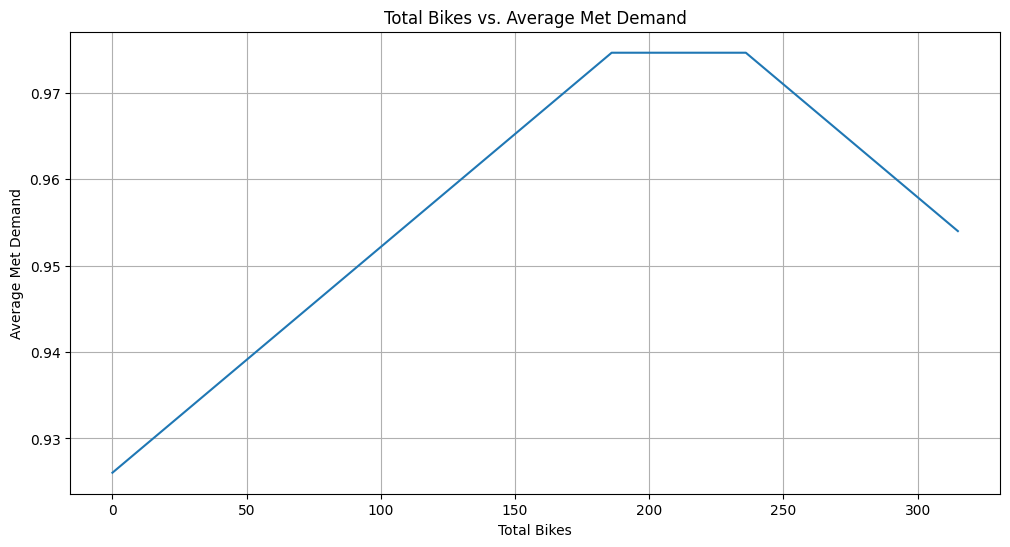

In [166]:
# Plot the results
plt.figure(figsize=(12, 6))
sns.lineplot(x='TOTAL_BIKES', y='SATISFIED_DEMAND', data=results_max)
plt.title("Total Bikes vs. Average Met Demand")
plt.xlabel("Total Bikes")
plt.ylabel("Average Met Demand")
plt.grid()

In [169]:
# print out the satisfied demand for the total bikes between 180 and 210:
results_max[(results_max['TOTAL_BIKES'] >= 200) & (results_max['TOTAL_BIKES'] <= 250)]

,TOTAL_BIKES,OPTIMAL_ALLOCATION,SATISFIED_DEMAND
200,200,"{'des Pins / St-Laurent': 22.0, 'du Mont-Royal...",0.974647
201,201,"{'des Pins / St-Laurent': 22.0, 'du Mont-Royal...",0.974647
202,202,"{'des Pins / St-Laurent': 22.0, 'du Mont-Royal...",0.974647
203,203,"{'des Pins / St-Laurent': 22.0, 'du Mont-Royal...",0.974647
204,204,"{'des Pins / St-Laurent': 22.0, 'du Mont-Royal...",0.974647
205,205,"{'des Pins / St-Laurent': 22.0, 'du Mont-Royal...",0.974647
206,206,"{'des Pins / St-Laurent': 22.0, 'du Mont-Royal...",0.974647
207,207,"{'des Pins / St-Laurent': 22.0, 'du Mont-Royal...",0.974647
208,208,"{'des Pins / St-Laurent': 22.0, 'du Mont-Royal...",0.974647
209,209,"{'des Pins / St-Laurent': 22.0, 'du Mont-Royal...",0.974647


In [ ]:
# Create a plot to visualize the distribution of the different allocations


Create a TSP where we need want to find the optimal path for an operator to redistribute the bikes across the top 10 stations in order for them to be ready for a new day 

In [20]:
import math

# Function that will calculate the distance between two points on the Earth in km
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points on the Earth using the Haversine formula.
    
    Parameters:
    lat1, lon1 : float : Latitude and longitude of the first point in decimal degrees
    lat2, lon2 : float : Latitude and longitude of the second point in decimal degrees
    
    Returns:
    float : Distance in kilometers
    """
    # Radius of Earth in kilometers
    R = 6371.0

    # Convert degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Differences in coordinates
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad

    # Haversine formula
    a = math.sin(delta_lat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(delta_lon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distance in kilometers
    distance = R * c
    return distance


If the truck achieves 15 L/100 km with a moderate load and fuel costs CAD 1.80/L:

 =0.27CAD/km
Thus, driving 1 km in such a loaded pickup could cost around 27–35 cents/km in fuel alone.

In [21]:
top_10.head()

,STATIONNAME,OPTIMAL_ALLOCATION,SATISFIED_DEMAND,CAPACITY,NUMBER_OF_DEMANDS
8,des Pins / St-Laurent,22,0.972163,23,467
36,du Mont-Royal / Clark,30,1.000000,39,454
35,Prince-Arthur / du Parc,20,1.000000,35,430
24,Marquette / du Mont-Royal,16,1.000000,23,423
81,Métro Mont-Royal (Utilités publiques / Rivard),16,1.000000,23,420


In [22]:
# add the coordiantes of the stations to top_10
for s in stations:
    top_10.loc[top_10['STATIONNAME'] == s, 'LATITUDE'] = data[data['STATIONNAME'] == s]['LATITUDE'].values[0]
    top_10.loc[top_10['STATIONNAME'] == s, 'LONGITUDE'] = data[data['STATIONNAME'] == s]['LONGITUDE'].values[0]

top_10.head(10)


C:\Users\utilisateur\AppData\Local\Temp\ipykernel_28980\412697871.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10.loc[top_10['STATIONNAME'] == s, 'LATITUDE'] = data[data['STATIONNAME'] == s]['LATITUDE'].values[0]
C:\Users\utilisateur\AppData\Local\Temp\ipykernel_28980\412697871.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10.loc[top_10['STATIONNAME'] == s, 'LONGITUDE'] = data[data['STATIONNAME'] == s]['LONGITUDE'].values[0]


,STATIONNAME,OPTIMAL_ALLOCATION,SATISFIED_DEMAND,CAPACITY,NUMBER_OF_DEMANDS,LATITUDE,LONGITUDE
8,des Pins / St-Laurent,22,0.972163,23,467,45.515228,-73.575096
36,du Mont-Royal / Clark,30,1.000000,39,454,45.519410,-73.586850
35,Prince-Arthur / du Parc,20,1.000000,35,430,45.510590,-73.575470
24,Marquette / du Mont-Royal,16,1.000000,23,423,45.532290,-73.575440
81,Métro Mont-Royal (Utilités publiques / Rivard),16,1.000000,23,420,45.524236,-73.581552
20,Clark / Prince-Arthur,27,0.982507,31,343,45.513303,-73.572961
12,Laurier / St-Denis,25,1.000000,37,337,45.527148,-73.589479
97,University / Prince-Arthur,0,0.917431,47,327,45.507402,-73.578444
33,Aylmer / Prince-Arthur,11,0.990769,31,325,45.508567,-73.577698
11,Boyer / du Mont-Royal,22,0.983333,27,300,45.527432,-73.579917


In [23]:
# Create the distance matrix
distances = pd.DataFrame(index=stations, columns=stations)

for i in range(len(stations)):
    for j in range(len(stations)):
        distances.iloc[i, j] = haversine(
            top_10.loc[top_10['STATIONNAME'] == stations[i], 'LATITUDE'].values[0],
            top_10.loc[top_10['STATIONNAME'] == stations[i], 'LONGITUDE'].values[0],
            top_10.loc[top_10['STATIONNAME'] == stations[j], 'LATITUDE'].values[0],
            top_10.loc[top_10['STATIONNAME'] == stations[j], 'LONGITUDE'].values[0]
        )

distances

# Convert to a 2D list
distances_list = distances.values.tolist()

In [26]:
# Check and create all the parameters needed for the model
stations = top_10['STATIONNAME'].values
optimal_bikes = top_10['OPTIMAL_ALLOCATION'].values
total_bikes = sum(optimal_bikes)  # Total number of bikes to allocate
capacities = top_10['CAPACITY'].values
print(optimal_bikes)
print(f"Total bikes from optimal allocation: {total_bikes}")

# Create a random allocation of bikes
import random
# random.seed(0)

# Ensure random allocation for the first station is >= to its optimal allocation
def initialize_random_allocation(optimal_bikes, capacities, total_bikes):
    random_bikes = [0] * len(optimal_bikes)
    # Start by setting the first station to at least its optimal allocation
    random_bikes[0] = max(optimal_bikes[0], random.randint(optimal_bikes[0], capacities[0]))

    # Allocate remaining bikes proportionally to the capacities
    remaining_bikes = total_bikes - random_bikes[0]
    for i in range(1, len(random_bikes)):
        random_bikes[i] = min(random.randint(0, capacities[i]), remaining_bikes)
        remaining_bikes -= random_bikes[i]
        if remaining_bikes == 0:
            break

    # Adjust random allocation to ensure the sum matches the total bikes
    return adjust_random_allocation(random_bikes, total_bikes, capacities)

# Adjust random allocation to ensure the sum equals `total_bikes`
def adjust_random_allocation(random_bikes, total_bikes, capacities):
    current_total = sum(random_bikes)
    while current_total != total_bikes:
        for i in range(len(random_bikes)):
            if current_total < total_bikes and random_bikes[i] < capacities[i]:
                random_bikes[i] += 1  # Increment until reaching the target
                current_total += 1
            elif current_total > total_bikes and random_bikes[i] > 0:
                random_bikes[i] -= 1  # Decrement if exceeding the target
                current_total -= 1
            if current_total == total_bikes:
                break
    return random_bikes

random_bikes = initialize_random_allocation(optimal_bikes, capacities, 186)

# Output results
print(f"Optimal allocation of bikes: {optimal_bikes}")
print(f"Random allocation of bikes: {random_bikes}")
print(f"Sum of random bikes: {sum(random_bikes)}")


[22 30 20 16 16 27 25  0 11 22]
Total bikes from optimal allocation: 189
Optimal allocation of bikes: [22 30 20 16 16 27 25  0 11 22]
Random allocation of bikes: [23, 24, 20, 15, 13, 22, 8, 23, 14, 24]
Sum of random bikes: 186


In [27]:
random_bikes = initialize_random_allocation(optimal_bikes, capacities, 186)
random_bikes

[np.int64(22), 13, 11, 21, 22, 28, 33, 26, np.int64(10), 0]

In [28]:
optimal_allocation

array([22, 30, 20, 16, 16, 27, 25,  0, 11, 22, 31, 19, 16,  3,  8, 10, 38,
       22, 22, 23])

In [29]:
random_bikes = initialize_random_allocation(optimal_bikes, capacities, total_bikes)
n = len(stations)  # Number of stations
start_station = 0  # Start station index

# Gurobi Model
model = gb.Model("Bixi TSP")

# Decision Variables
x = model.addVars(n, n, vtype=gb.GRB.BINARY, name=[f"x{i}_{j}" for i in range(n) for j in range(n)])  # Route variables
b = model.addVars(n, lb=0, vtype=gb.GRB.INTEGER, name=[f"Bikes after station  {i}" for i in range(n)])  # Bikes carried

# Objective: Minimize total distance
model.setObjective(gb.quicksum(x[i, j] * distances_list[i][j] for i in range(n) for j in range(n) if i != j), gb.GRB.MINIMIZE)

# Constraints
# 1. Each station is visited exactly once
model.addConstrs(gb.quicksum(x[i, j] for j in range(n) if i != j) == 1 for i in range(n))  # Leave
model.addConstrs(gb.quicksum(x[j, i] for j in range(n) if i != j) == 1 for i in range(n))  # Arrive

# 2. Start and end at the start station
model.addConstr(gb.quicksum(x[start_station, j] for j in range(n) if j != start_station) == 1)
model.addConstr(gb.quicksum(x[j, start_station] for j in range(n) if j != start_station) == 1)

# 3. Subtour elimination
u = model.addVars(n, lb=0, ub=n - 1, vtype=gb.GRB.CONTINUOUS, name="u")
model.addConstrs(
    (u[i] - u[j] + n * x[i, j] <= n - 1 for i in range(1, n) for j in range(1, n) if i != j),
    name="subtour_elimination",
)

# 4. Redistribution constraints
# Start station bike balance
model.addConstr(b[start_station] == random_bikes[start_station] - optimal_bikes[start_station])



# Update redistribution balance as the operator travels
M = 500
model.addConstrs(
    b[j] <= b[i] + (random_bikes[j] - optimal_bikes[j]) + M * (1 - x[i, j]) 
    for i in range(n) for j in range(n) if i != j
)

model.addConstrs(
    b[j] >= b[i] + (random_bikes[j] - optimal_bikes[j]) - M * (1 - x[i, j]) 
    for i in range(n) for j in range(n) if i != j
)
# Redistribution capacity constraints (e.g., truck capacity)
truck_capacity = max(sum(random_bikes), sum(optimal_bikes))  # Adjust as needed
model.addConstrs((b[i] <= total_bikes for i in range(n)), name="truck_capacity")
model.addConstrs((b[i] >= 0 for i in range(n)), name="non_negative_bikes")

# Solve the model
model.optimize()

# Output Results
if model.status == gb.GRB.OPTIMAL:
    print(f"Optimal Total Distance: {model.objVal} km")
    # Extract the route
    route = []
    current = start_station
    visited = set([current])
    while len(visited) < n:
        for j in range(n):
            if x[current, j].X > 0.5 and j not in visited:
                route.append((current, j))
                current = j
                visited.add(j)
                break
    print("Optimal Route:", " -> ".join([stations[i] for i, j in route]))
    # Extract redistribution plan
    redistribution = {stations[i]: b[i].X for i in range(n)}
    print("Redistribution Plan:", redistribution)
else:
    print("No optimal solution found.")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-6300U CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 295 rows, 120 columns and 975 nonzeros
Model fingerprint: 0x9090b2d9
Variable types: 10 continuous, 110 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [1e-01, 3e+00]
  Bounds range     [1e+00, 9e+00]
  RHS range        [1e+00, 5e+02]
Presolve removed 47 rows and 21 columns
Presolve time: 0.02s
Presolved: 248 rows, 99 columns, 1130 nonzeros
Variable types: 9 continuous, 90 integer (81 binary)
Found heuristic solution: objective 12.0022863

Root relaxation: objective 5.145642e+00, 36 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time



In [38]:
random_bikes

[23, 6, 16, 17, 18, 20, 25, 42, np.int64(22), 0]

In [16]:
top20 = results.head(20)
display(top20)

,STATIONNAME,OPTIMAL_ALLOCATION,SATISFIED_DEMAND,CAPACITY,NUMBER_OF_DEMANDS
8,des Pins / St-Laurent,22,0.972163,23,467
36,du Mont-Royal / Clark,30,1.000000,39,454
35,Prince-Arthur / du Parc,20,1.000000,35,430
24,Marquette / du Mont-Royal,16,1.000000,23,423
81,Métro Mont-Royal (Utilités publiques / Rivard),16,1.000000,23,420
20,Clark / Prince-Arthur,27,0.982507,31,343
12,Laurier / St-Denis,25,1.000000,37,337
97,University / Prince-Arthur,0,0.917431,47,327
33,Aylmer / Prince-Arthur,11,0.990769,31,325
11,Boyer / du Mont-Royal,22,0.983333,27,300


In [ ]:
optimal_allocation = top20['OPTIMAL_ALLOCATION'].values
capacities = top20['CAPACITY'].values
total_bikes = sum(optimal_allocation)

array([22, 30, 20, 16, 16, 27, 25,  0, 11, 22, 31, 19, 16,  3,  8, 10, 38,
       22, 22, 23])